In [31]:
pip install pytorch-lightning  

In [32]:
pip install pytorch-forecasting

In [33]:
import os

import warnings
warnings.filterwarnings('ignore')

import pickle

import numpy as np
import pandas as pd
from typing import Dict, Callable, List, Optional, Tuple, Union

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import torch

import pytorch_lightning as pl

In [34]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet

In [35]:
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, distributions, BaseEstimator

In [36]:
class MultivariateDistributionLoss(DistributionLoss):
    """Base class for multivariate distribution losses.
    Class should be inherited for all multivariate distribution losses, i.e. if a batch of values
    is predicted in one go and the batch dimension is not independent, but the time dimension still
    remains independent.
    """

    def sample(self, y_pred, n_samples: int) -> torch.Tensor:
        """
        Sample from distribution.
        Args:
            y_pred: prediction output of network (shape batch_size x n_timesteps x n_paramters)
            n_samples (int): number of samples to draw
        Returns:
            torch.Tensor: tensor with samples  (shape batch_size x n_timesteps x n_samples)
        """
        dist = self.map_x_to_distribution(y_pred)
        samples = dist.sample((n_samples,)).permute(
            2, 1, 0
        )  # returned as (n_samples, n_timesteps, batch_size), so reshape to (batch_size, n_timesteps, n_samples)
        return samples

    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.
        Args:
            y_pred: prediction output of network
        Returns:
            torch.Tensor: mean prediction
        """
        distribution = self.map_x_to_distribution(y_pred)

        return distribution.mean.transpose(0, 1)  # switch to batch_size x n_timesteps

    def loss(self, y_pred: torch.Tensor, y_actual: torch.Tensor) -> torch.Tensor:
        """
        Calculate negative likelihood
        Args:
            y_pred: network output
            y_actual: actual values
        Returns:
            torch.Tensor: metric value on which backpropagation can be applied
        """
        distribution = self.map_x_to_distribution(y_pred)
        # calculate one number and scale with batch size
        loss = -distribution.log_prob(y_actual.transpose(0, 1)).sum() * y_actual.size(0)
        return loss

In [37]:
import torch.nn.functional as F
class MultivariateNormalDistributionLoss(MultivariateDistributionLoss):
    """
    Multivariate low-rank normal distribution loss.
    Use this loss to make out of a DeepAR model a DeepVAR network.
    Requirements for original target normalizer:
        * not normalized in log space (use :py:class:`~LogNormalDistributionLoss`)
        * not coerced to be positive
    """

    distribution_class = distributions.LowRankMultivariateNormal

    def __init__(
        self,
        name: str = None,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        reduction: str = "mean",
        rank: int = 10,
        sigma_init: float = 1.0,
        sigma_minimum: float = 1e-3,
    ):
        """
        Initialize metric
        Args:
            name (str): metric name. Defaults to class name.
            quantiles (List[float], optional): quantiles for probability range.
                Defaults to [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98].
            reduction (str, optional): Reduction, "none", "mean" or "sqrt-mean". Defaults to "mean".
            rank (int): rank of low-rank approximation for covariance matrix. Defaults to 10.
            sigma_init (float, optional): default value for diagonal covariance. Defaults to 1.0.
            sigma_minimum (float, optional): minimum value for diagonal covariance. Defaults to 1e-3.
        """
        super().__init__(name=name, quantiles=quantiles, reduction=reduction)
        self.rank = rank
        self.sigma_minimum = sigma_minimum
        self.sigma_init = sigma_init
        self.distribution_arguments = list(range(2 + rank))

        # determine bias
        self._diag_bias: float = self.inv_softplus(self.sigma_init**2) if self.sigma_init > 0.0 else 0.0

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        x = x.permute(1, 0, 2)
        return self.distribution_class(
            loc=x[..., 0],
            cov_factor=x[..., 2:],
            cov_diag=x[..., 1],
        )

    @staticmethod
    def validate_encoder(encoder: BaseEstimator):
        assert encoder.transformation not in [
            "log",
            "log1p",
        ], "Use MultivariateLogNormalDistributionLoss for log scaled data"  # todo: implement
        assert encoder.transformation not in [
            "softplus",
            "relu",
        ], "Cannot use NormalDistributionLoss for positive data"
        assert encoder.transformation not in ["logit"], "Cannot use bound transformation such as 'logit'"

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
        self.validate_encoder(encoder)

        # scale
        loc = encoder(dict(prediction=parameters[..., 0], target_scale=target_scale)).unsqueeze(-1)
        scale = (
            F.softplus(parameters[..., 1].unsqueeze(-1) + self._diag_bias) + self.sigma_minimum**2
        ) * target_scale[..., 1, None, None] ** 2

        cov_factor = parameters[..., 2:] * target_scale[..., 1, None, None]
        return torch.concat([loc, scale, cov_factor], dim=-1)

    def inv_softplus(self, y):
        if y < 20.0:
            return np.log(np.exp(y) - 1.0)
        else:
            return y

### Data 생성


In [38]:
with open('crypto_currency.pickle', 'rb') as f:
  data = pickle.load(f)

In [39]:
data['KRW-BTT'].head(3)

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate,MA5,MA20,MA60
199,KRW-BTT,2019-12-22T00:00:00,2019-12-22T09:00:00,0.00034,0.00035,0.00032,0.00035,1577059163459,3.875621e+08,1.142348e+12,0.00033,0.00002,0.060606,NaN,NaN,NaN
198,KRW-BTT,2019-12-23T00:00:00,2019-12-23T09:00:00,0.00035,0.00035,0.00032,0.00033,1577145521354,2.354836e+08,7.014280e+11,0.00035,-0.00002,-0.057143,NaN,NaN,NaN
197,KRW-BTT,2019-12-24T00:00:00,2019-12-24T09:00:00,0.00033,0.00034,0.00032,0.00033,1577231846379,2.195037e+08,6.680056e+11,0.00033,NaN,0.000000,NaN,NaN,NaN


In [40]:
[x for (x, y) in data.items() if len(y) == 720]

['KRW-ZIL',
 'KRW-SC',
 'KRW-STMX',
 'KRW-TRX',
 'KRW-SNT',
 'KRW-LOOM',
 'KRW-XRP',
 'KRW-POWR',
 'KRW-XEM',
 'KRW-STRAX',
 'KRW-XLM',
 'KRW-ARDR',
 'KRW-ADA',
 'KRW-GLM',
 'KRW-ZRX',
 'KRW-POLY',
 'KRW-ICX',
 'KRW-ONT',
 'KRW-WAVES',
 'KRW-GRS',
 'KRW-STEEM',
 'KRW-EOS',
 'KRW-ARK',
 'KRW-STORJ',
 'BTC-DGB',
 'KRW-OMG',
 'KRW-ETC',
 'KRW-LSK',
 'KRW-MTL',
 'KRW-QTUM',
 'BTC-MFT',
 'BTC-SC',
 'BTC-STMX',
 'BTC-DNT',
 'BTC-LRC',
 'KRW-SBD',
 'BTC-TRX',
 'KRW-REP',
 'KRW-NEO',
 'BTC-LOOM',
 'BTC-XRP',
 'KRW-BTG',
 'BTC-DOGE',
 'USDT-TRX',
 'BTC-SNT',
 'KRW-LTC',
 'BTC-VAL',
 'BTC-XLM',
 'BTC-RLC',
 'BTC-ARDR',
 'KRW-ETH',
 'USDT-SC',
 'BTC-POWR',
 'BTC-CVC',
 'USDT-XRP',
 'BTC-XEM',
 'KRW-BCH']

In [41]:
d1 = data['KRW-ZIL']

In [42]:
d1 = d1.sort_values('candle_date_time_kst')

In [43]:
d1['time_index'] = np.arange(len(d1))

In [44]:
date_index = d1[['time_index', 'candle_date_time_kst']]

In [45]:
date_index.head()

,time_index,candle_date_time_kst
119,0,2018-07-20T09:00:00
118,1,2018-07-21T09:00:00
117,2,2018-07-22T09:00:00
116,3,2018-07-23T09:00:00
115,4,2018-07-24T09:00:00


In [46]:
res_data = pd.DataFrame()
scalers = {}

for i, key in enumerate(data.keys()):
  tmp = data[key]
  tmp_1 = pd.merge(tmp, date_index, on = 'candle_date_time_kst')
  tmp_df_1 = tmp_1[['time_index', 'candle_date_time_kst', 'market']]

  # Scaling
  scaler = MinMaxScaler()
  scale_col = ['candle_acc_trade_volume', 'trade_price']
  scaled = scaler.fit_transform(tmp[scale_col])
  tmp_df_2 = pd.DataFrame(scaled, columns = ['candle_acc_trade_volume', 'trade_price'])
  tmp_res = pd.concat([tmp_df_1, tmp_df_2], axis = 1)

  res_data = pd.concat([res_data, tmp_res])
  scalers[key] = scaler

In [47]:

res_data.shape

(103848, 5)

In [48]:
res_data[res_data['time_index'].isna()]

,time_index,candle_date_time_kst,market,candle_acc_trade_volume,trade_price
399,NaN,NaN,NaN,0.018256,0.427119
581,NaN,NaN,NaN,0.008484,0.110635
582,NaN,NaN,NaN,0.016607,0.109777
583,NaN,NaN,NaN,0.005450,0.110635
584,NaN,NaN,NaN,0.003582,0.104631
...,...,...,...,...,...
668,NaN,NaN,NaN,0.001961,0.171974
669,NaN,NaN,NaN,0.001437,0.190391
670,NaN,NaN,NaN,0.000050,0.186803
671,NaN,NaN,NaN,0.000786,0.185630


In [49]:
res_data.dropna(inplace = True)

In [50]:
res_data['time_index'] = res_data['time_index'].astype(int)

In [51]:
res_data.shape

(101553, 5)

In [52]:
max_encoder_length = 60
max_prediction_length = 20
training_cutoff = res_data['time_index'].max() - max_prediction_length

In [53]:
training_cutoff

699

In [54]:
training = TimeSeriesDataSet(
  res_data[lambda x: x.time_index <= training_cutoff],
  time_idx = 'time_index',
  target = 'trade_price',
  categorical_encoders = {'market': NaNLabelEncoder().fit(res_data.market)},
  group_ids = ['market'],
  time_varying_unknown_reals = ['trade_price'],
  # time_varying_known_reals = ['candle_acc_trade_volume'],
  max_encoder_length = max_encoder_length,
  max_prediction_length = max_prediction_length,
  allow_missing_timesteps = True
)

AssertionError: ignored

In [ ]:
validation = TimeSeriesDataSet.from_dataset(
    training,
    res_data,
    min_prediction_idx = training_cutoff + 1
)

In [ ]:
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)

### Calculate baseline errror

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [ ]:
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.2572)

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus = 1, gradient_clip_val = .1)
net = DeepAR.from_dataset(
    training, 
    learning_rate = 3e-2, 
    hidden_size = 200, 
    rnn_layers = 2, 
   loss = MultivariateNormalDistributionLoss()
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()

In [ ]:
trainer = pl.Trainer(
    max_epochs = 10,
    gpus = 1,
    weights_summary = 'top', ##
    gradient_clip_val = .01,
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches = 30,
    enable_checkpointing = True,
    # auto_lr_find = True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    net,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 0     
3 | rnn                    | LSTM                               | 484 K 
4 | distribution_projector | Linear                             | 2.4 K 
------------------------------------------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.946     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -199.111


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 19.811 >= min_delta = 0.0001. New best score: -218.922


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 27.917 >= min_delta = 0.0001. New best score: -246.839


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 16.286 >= min_delta = 0.0001. New best score: -263.125


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.563 >= min_delta = 0.0001. New best score: -269.688


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.639 >= min_delta = 0.0001. New best score: -273.327


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.929 >= min_delta = 0.0001. New best score: -275.256


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.902 >= min_delta = 0.0001. New best score: -276.158


Validation: 0it [00:00, ?it/s]

In [ ]:
best_model_path

'/content/lightning_logs/version_0/checkpoints/epoch=9-step=300.ckpt'

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = net.load_from_checkpoint(best_model_path)

RuntimeError: ignored

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = net.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0776)

In [ ]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [ ]:
raw_predictions, x = net.predict(val_dataloader, mode = 'raw', return_x=True, n_samples=100)

In [ ]:
# for idx in range(2):  # plot 10 examples
for i in range(10):
    net.plot_prediction(x, raw_predictions, idx=i, add_loss_to_title=True)

RuntimeError: ignored

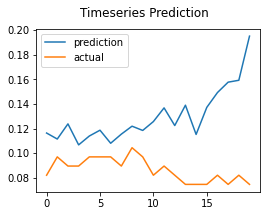

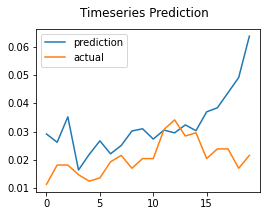

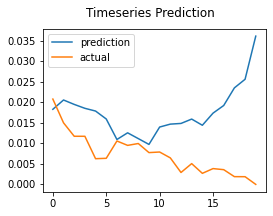

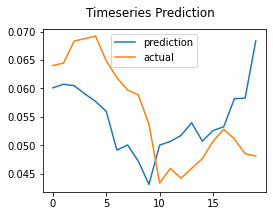

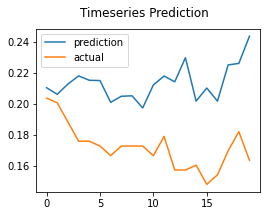

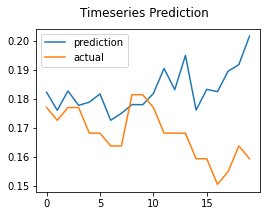

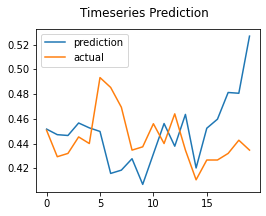

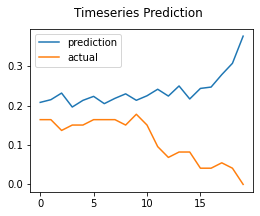

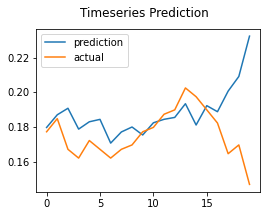

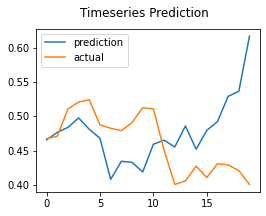

In [ ]:
raw_predictions, x = net.predict(val_dataloader, return_x=True, n_samples=100)
for i in np.arange(60, 70):
    plt.figure(figsize=(4, 3))
    plt.plot(raw_predictions[i], label='prediction')
    plt.plot(actuals[i], label='actual')
    plt.suptitle('Timeseries Prediction')
    plt.legend()
    plt.show()